In [3]:
import os
import sys
import pickle
import warnings
import time
import logging
import glob


import numpy as np
import matplotlib.pyplot as plt
from iminuit import Minuit
from matplotlib import ticker
from matplotlib.legend import Legend

from utils import *
from AnalyseDefects_dev import AnalyseDefects
from AnalyseDefectsAll import AnalyseDefectsAll

plt.style.use('sg_article')


In [4]:
def gen_analysis_dict(LL, mode):

    dshort = dict(path = f'C:\\Users\\Simon Andersen\\Documents\\Uni\\Speciale\\Hyperuniformity\\nematic_analysis{LL}_LL0.05', \
              suffix = "short", priority = -1, LX = LL, Nframes = 181)
    dlong = dict(path = f'C:\\Users\\Simon Andersen\\Documents\\Uni\\Speciale\\Hyperuniformity\\nematic_analysis{LL}_LL0.05_long', \
                suffix = "long", priority = 1, LX = LL, Nframes = 400)
    priority_vl = 2 if LL == 512 else 3
    dvery_long = dict(path = f'C:\\Users\\Simon Andersen\\Documents\\Uni\\Speciale\\Hyperuniformity\\nematic_analysis{LL}_LL0.05_very_long',\
                    suffix = "very_long", priority = priority_vl, LX = LL, Nframes = 1500)
    dvery_long2 = dict(path = f'C:\\Users\\Simon Andersen\\Documents\\Uni\\Speciale\\Hyperuniformity\\nematic_analysis{LL}_LL0.05_very_long_v2',\
                    suffix = "very_long2", priority = 3 if priority_vl == 2 else 2, LX = LL, Nframes = 1500)

    if mode == 'all':
        if LL == 2048:
            defect_list = [dshort, dlong]
        else:
            defect_list = [dshort, dlong, dvery_long, dvery_long2] if LL in [256, 512] else [dshort, dlong, dvery_long]
    else:
        defect_list = [dshort]
    
    return defect_list



STEP 1: Using window sizes

In [63]:
LL = 2048
output_path = f'data\\nematic_analysis{LL}_LL0.05'
mode = 'all' # 'all' or 'short'

defect_list = gen_analysis_dict(LL, mode)

ad = AnalyseDefects(defect_list, output_path=output_path)

extract = False
analyze = False
merge = False

In [6]:

def calc_skew_kurt(count_fluc_av, count_arr_av):

    count_arr_time_av = np.nanmean(count_arr_av, axis = 0)
    count_fluc_time_av = np.nanmean(count_fluc_av, axis = 0)


    skew = 2 * (count_fluc_time_av / count_arr_time_av ** 2) ** 0.5
    kurt = 6 * (count_fluc_time_av / count_arr_time_av ** 2)

    return skew, kurt


In [64]:
N = 2

def_arr, var_counts, dens_fluc, av_counts, av_def = ad.get_arrays_av(Ndataset=N, return_av_counts=True, use_merged=True)
act_list = ad.act_list[0]
av_counts_av = np.mean(av_counts, axis=0)
var_counts_av = np.mean(var_counts, axis=0)
dens_fluc_av = np.mean(dens_fluc, axis=0)
windows = ad.window_sizes[0]
skew, kurt = calc_skew_kurt(var_counts, av_counts)

av_dens = av_counts_av / (np.pi * (windows**2)[:,None,None])
var_counts_norm = var_counts_av / (np.pi * (windows**2)[:,None,None])

In [ ]:
fig, ax = plt.subplots(nrows = 2, figsize=(9,9))
ax = ax.flatten()

window_idx_bounds = [20,-2]
act_idx_bounds = [2, 20]

window_res = windows[window_idx_bounds[0]:window_idx_bounds[1]]

for i, act in enumerate(act_list[act_idx_bounds[0]:act_idx_bounds[1]]):

    act_idx = i + act_idx_bounds[0]

    ax[0].plot(window_res, skew[window_idx_bounds[0]:window_idx_bounds[1],act_idx,0], label=f'{act}', marker='o', alpha=.3)
    ax[1].plot(window_res, kurt[window_idx_bounds[0]:window_idx_bounds[1],act_idx,0], label=f'{act}', marker='o', alpha=.3)

for axx in ax:
    axx.set_xscale('log')
    axx.set_yscale('log')
    axx.set_xlabel('Window size')
    axx.set_ylabel('Skewness' if axx == ax[0] else 'Kurtosis')
    axx.legend(fontsize=8, ncol=3)

alpha22 = -0.88
skew_scaling22 = (2+alpha22)/2
kurt_scaling22 = 2*skew_scaling22
scale_from_idx = 6

ax[1].plot(windows[-scale_from_idx:window_idx_bounds[1]], kurt[-scale_from_idx,act_list.index(0.0215),0] * windows[-scale_from_idx:window_idx_bounds[1]]**(-kurt_scaling22) / windows[-scale_from_idx]**(-kurt_scaling22), label='1/sqrt(w)', color='black', linestyle='--')
ax[0].plot(windows[-scale_from_idx:window_idx_bounds[1]], skew[-scale_from_idx,act_list.index(0.0215),0] * windows[-scale_from_idx:window_idx_bounds[1]]**(-skew_scaling22) / windows[-scale_from_idx]**(-skew_scaling22), label='1/sqrt(w)', color='black', linestyle='--')
ax[0].plot(windows[-scale_from_idx:window_idx_bounds[1]], skew[-scale_from_idx,act_list.index(0.022),0] * windows[-scale_from_idx:window_idx_bounds[1]]**(-skew_scaling22) / windows[-scale_from_idx]**(-skew_scaling22), label='1/sqrt(w)', color='black', linestyle='--')
ax[0].plot(windows[-scale_from_idx:window_idx_bounds[1]], skew[-scale_from_idx,act_list.index(0.030),0] * windows[-scale_from_idx:window_idx_bounds[1]]**(-1) / windows[-scale_from_idx]**(-1), label='1/sqrt(w)', color='black', linestyle='--')
ax[1].plot(windows[-scale_from_idx:window_idx_bounds[1]], kurt[-scale_from_idx,act_list.index(0.022),0] * windows[-scale_from_idx:window_idx_bounds[1]]**(-kurt_scaling22) / windows[-scale_from_idx]**(-kurt_scaling22), label='1/sqrt(w)', color='black', linestyle='--')
ax[1].plot(windows[-scale_from_idx:window_idx_bounds[1]], kurt[-scale_from_idx,act_list.index(0.030),0] * windows[-scale_from_idx:window_idx_bounds[1]]**(-2) / windows[-scale_from_idx]**(-2), label='1/sqrt(w)', color='black', linestyle='--')

In [ ]:
fig, ax = plt.subplots(nrows = 2, figsize=(7,8))
ax = ax.flatten()

window_idx_bounds = [20,-2]
marker_shape = ['s', 'o', '^', 'v', 'D', 'P', 'X', 'h', 'd', 'p', 'H', '8', '1', '2']
act_list = ad.act_list[0]

acts_to_plot = [0.02, 0.021, 0.0215, 0.022, 0.0225, 0.024, 0.026, 0.03, 0.034, 0.04, 0.05, 0.06]
if ad.LX[0] == 2048:
    acts_to_plot = [0.02, 0.021, 0.0215, 0.022, 0.024, 0.026, 0.03, 0.034, 0.04, 0.05, 0.06]

window_res = windows[window_idx_bounds[0]:window_idx_bounds[1]]

for i, act in enumerate(acts_to_plot):

    act_idx = act_list.index(act)

    ax[0].plot(window_res, skew[window_idx_bounds[0]:window_idx_bounds[1],act_idx,0], \
               label=f'{act}', marker=marker_shape[i], alpha=.5)
    ax[1].plot(window_res, kurt[window_idx_bounds[0]:window_idx_bounds[1],act_idx,0],\
                label=f'{act}', marker=marker_shape[i], alpha=.5)

for axx in ax:
    axx.set_xscale('log')
    axx.set_yscale('log')
    axx.set_xlabel('Window size')
    axx.set_ylabel('Skewness' if axx == ax[0] else 'Kurtosis')
    axx.legend(fontsize=8, ncol=3)

alpha22 = -0.9
skew_scaling22 = (2+alpha22)/2
kurt_scaling22 = 2*skew_scaling22
scale_from_idx = 6

ax[0].plot(windows[-scale_from_idx:window_idx_bounds[1]], skew[-scale_from_idx,act_list.index(0.022),0] * windows[-scale_from_idx:window_idx_bounds[1]]**(-skew_scaling22) / windows[-scale_from_idx]**(-skew_scaling22), label='1/sqrt(w)', color='black', linestyle='--')
ax[0].plot(windows[-scale_from_idx:window_idx_bounds[1]], skew[-scale_from_idx,act_list.index(0.030),0] * windows[-scale_from_idx:window_idx_bounds[1]]**(-1) / windows[-scale_from_idx]**(-1), label='1/sqrt(w)', color='black', linestyle='--')
ax[1].plot(windows[-scale_from_idx:window_idx_bounds[1]], kurt[-scale_from_idx,act_list.index(0.022),0] * windows[-scale_from_idx:window_idx_bounds[1]]**(-kurt_scaling22) / windows[-scale_from_idx]**(-kurt_scaling22), label='1/sqrt(w)', color='black', linestyle='--')
ax[1].plot(windows[-scale_from_idx:window_idx_bounds[1]], kurt[-scale_from_idx,act_list.index(0.030),0] * windows[-scale_from_idx:window_idx_bounds[1]]**(-2) / windows[-scale_from_idx]**(-2), label='1/sqrt(w)', color='black', linestyle='--')

In [99]:
def produce_scaling(X, scaling_exp, Y0, x_bounds,):
    x = X[x_bounds[0]:x_bounds[1]]

    return x, Y0 * x**scaling_exp / x[0]**scaling_exp

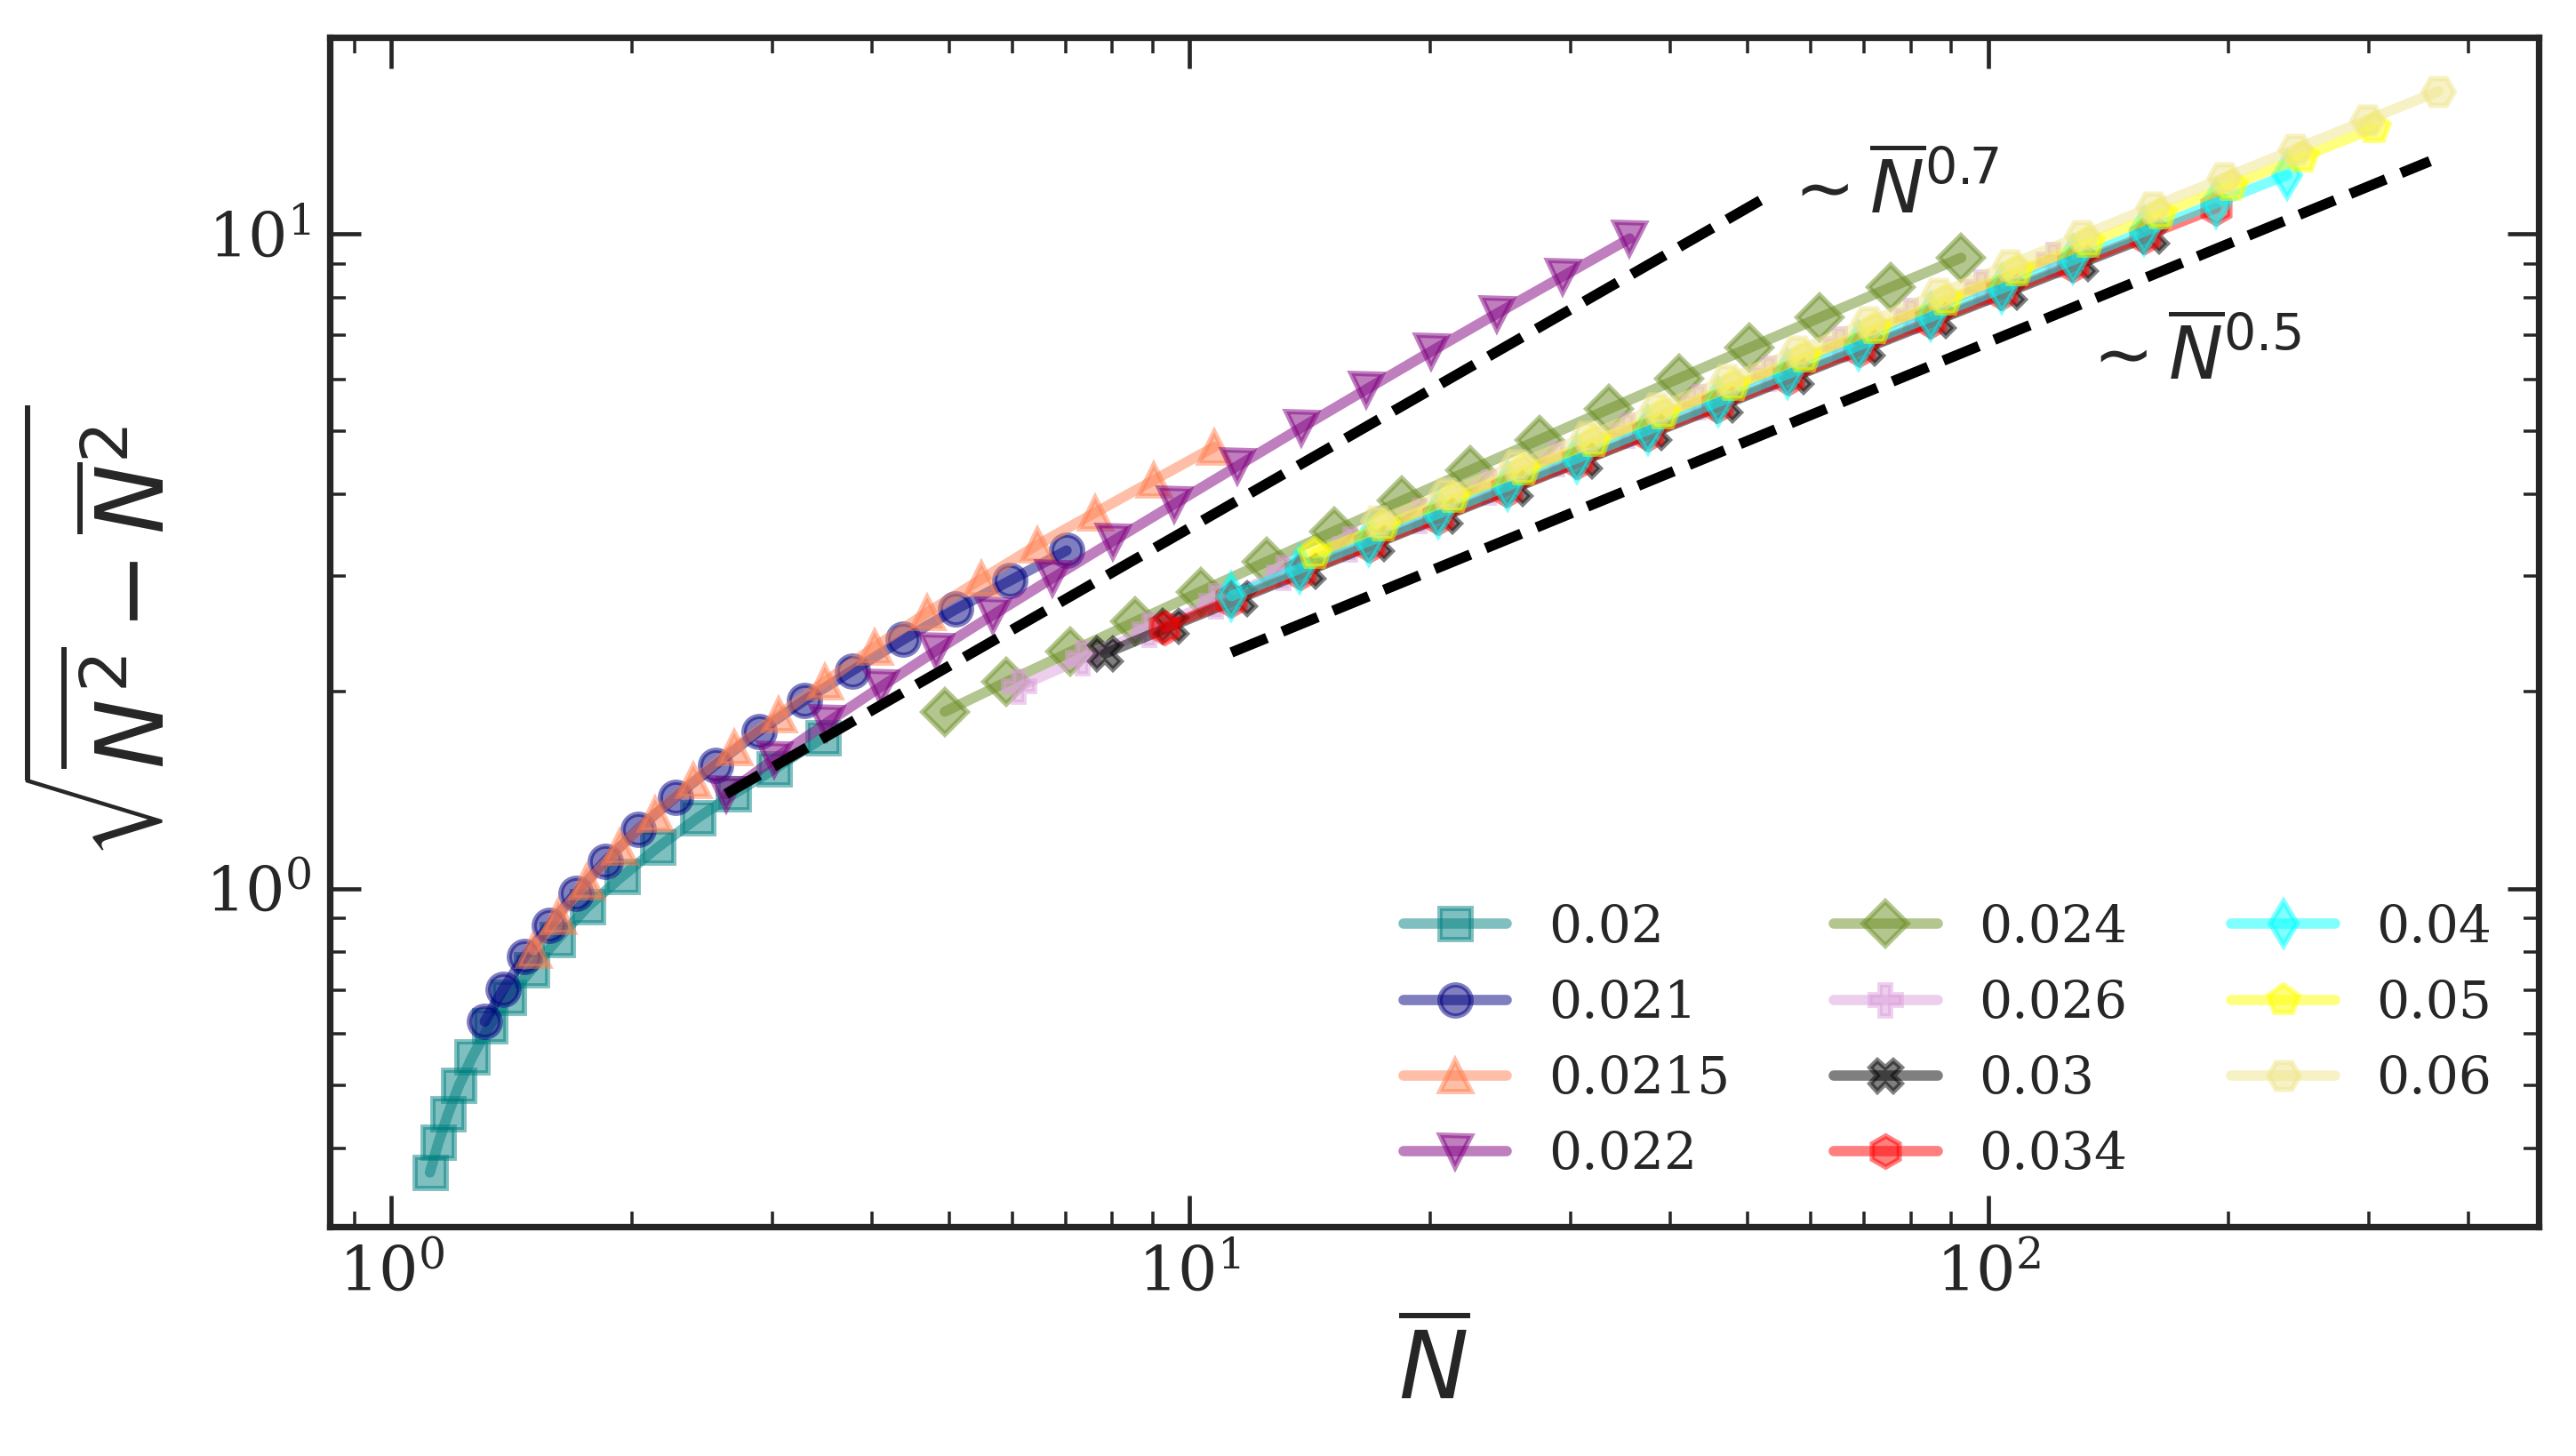

In [159]:

fig, ax = plt.subplots(figsize=(7,4))
window_idx_bounds = [10,-4]

marker_shape = ['s', 'o', '^', 'v', 'D', 'P', 'X', 'h', 'd', 'p', 'H', '8', '1', '2']
act_list = ad.act_list[0]

acts_to_plot = [0.02, 0.021, 0.0215, 0.022, 0.0225, 0.024, 0.026, 0.03, 0.034, 0.04, 0.05, 0.06]
if ad.LX[0] == 2048:
    acts_to_plot = [0.02, 0.021, 0.0215, 0.022, 0.024, 0.026, 0.03, 0.034, 0.04, 0.05, 0.06]
for i, act in enumerate(acts_to_plot):
    idx = act_list.index(act)
    ax.plot(av_counts_av[window_idx_bounds[0]:window_idx_bounds[1],idx,0], np.sqrt(var_counts_av[window_idx_bounds[0]:window_idx_bounds[1],idx,0]),\
             label=f'{act}', marker=marker_shape[i], alpha=.5)


idx22 = act_list.index(0.022)
idx40 = act_list.index(0.040)
scaling22 = (1+0.8/2)/2
window_idx_bounds = [10,-2]

x22, y22 = produce_scaling(av_counts_av[:, idx22, 0], scaling22, np.sqrt(var_counts_av[window_idx_bounds[0],idx22,0]), window_idx_bounds,)
x40, y40 = produce_scaling(av_counts_av[:, idx40, 0], .5, np.sqrt(var_counts_av[window_idx_bounds[0],idx40,0]), window_idx_bounds,)
ax.plot(x22, y22, color='black', linestyle='--')
ax.plot(x40, y40*0.82,  color='black', linestyle='--')
ax.text(130,6, r'$\sim \overline{N}^{0.5}$', fontsize=14)
ax.text(55,10.8, r'$\sim \overline{N}^{0.7}$', fontsize=14)
#ax.plot(av_counts_av[:,idx,0], 0.8*av_counts_av[:,idx,0]**0.69, label=r'$\sim x^{0.7}$', color='black', lw=1.5, linestyle='--')
#ax.plot(av_counts_av[:,idx,0], 0.8*av_counts_av[:,idx,0]**0.5,label=r'$\sim x^{0.5}$', color='black', lw=1.5, linestyle='-')


ax.set_xlabel(r'$\overline{N}$')
ax.set_ylabel(r'$\sqrt{\overline{N^2} - \overline{N}^2}$')
#ax.set_ylim(.5,8)
#ax.set_xlim(1,100)
ax.legend(ncols=3,fontsize=10)
ax.set_xscale('log')
ax.set_yscale('log')


STEP 2: Using susceptibilities

In [124]:
system_size_list = [256, 512,1024, 2048]
#system_size_list = [2048]
ada = AnalyseDefectsAll(system_size_list)

from AnalyseDefectsAll import AnalyseDefectsAll as AnDef
adaa = AnDef(system_size_list)

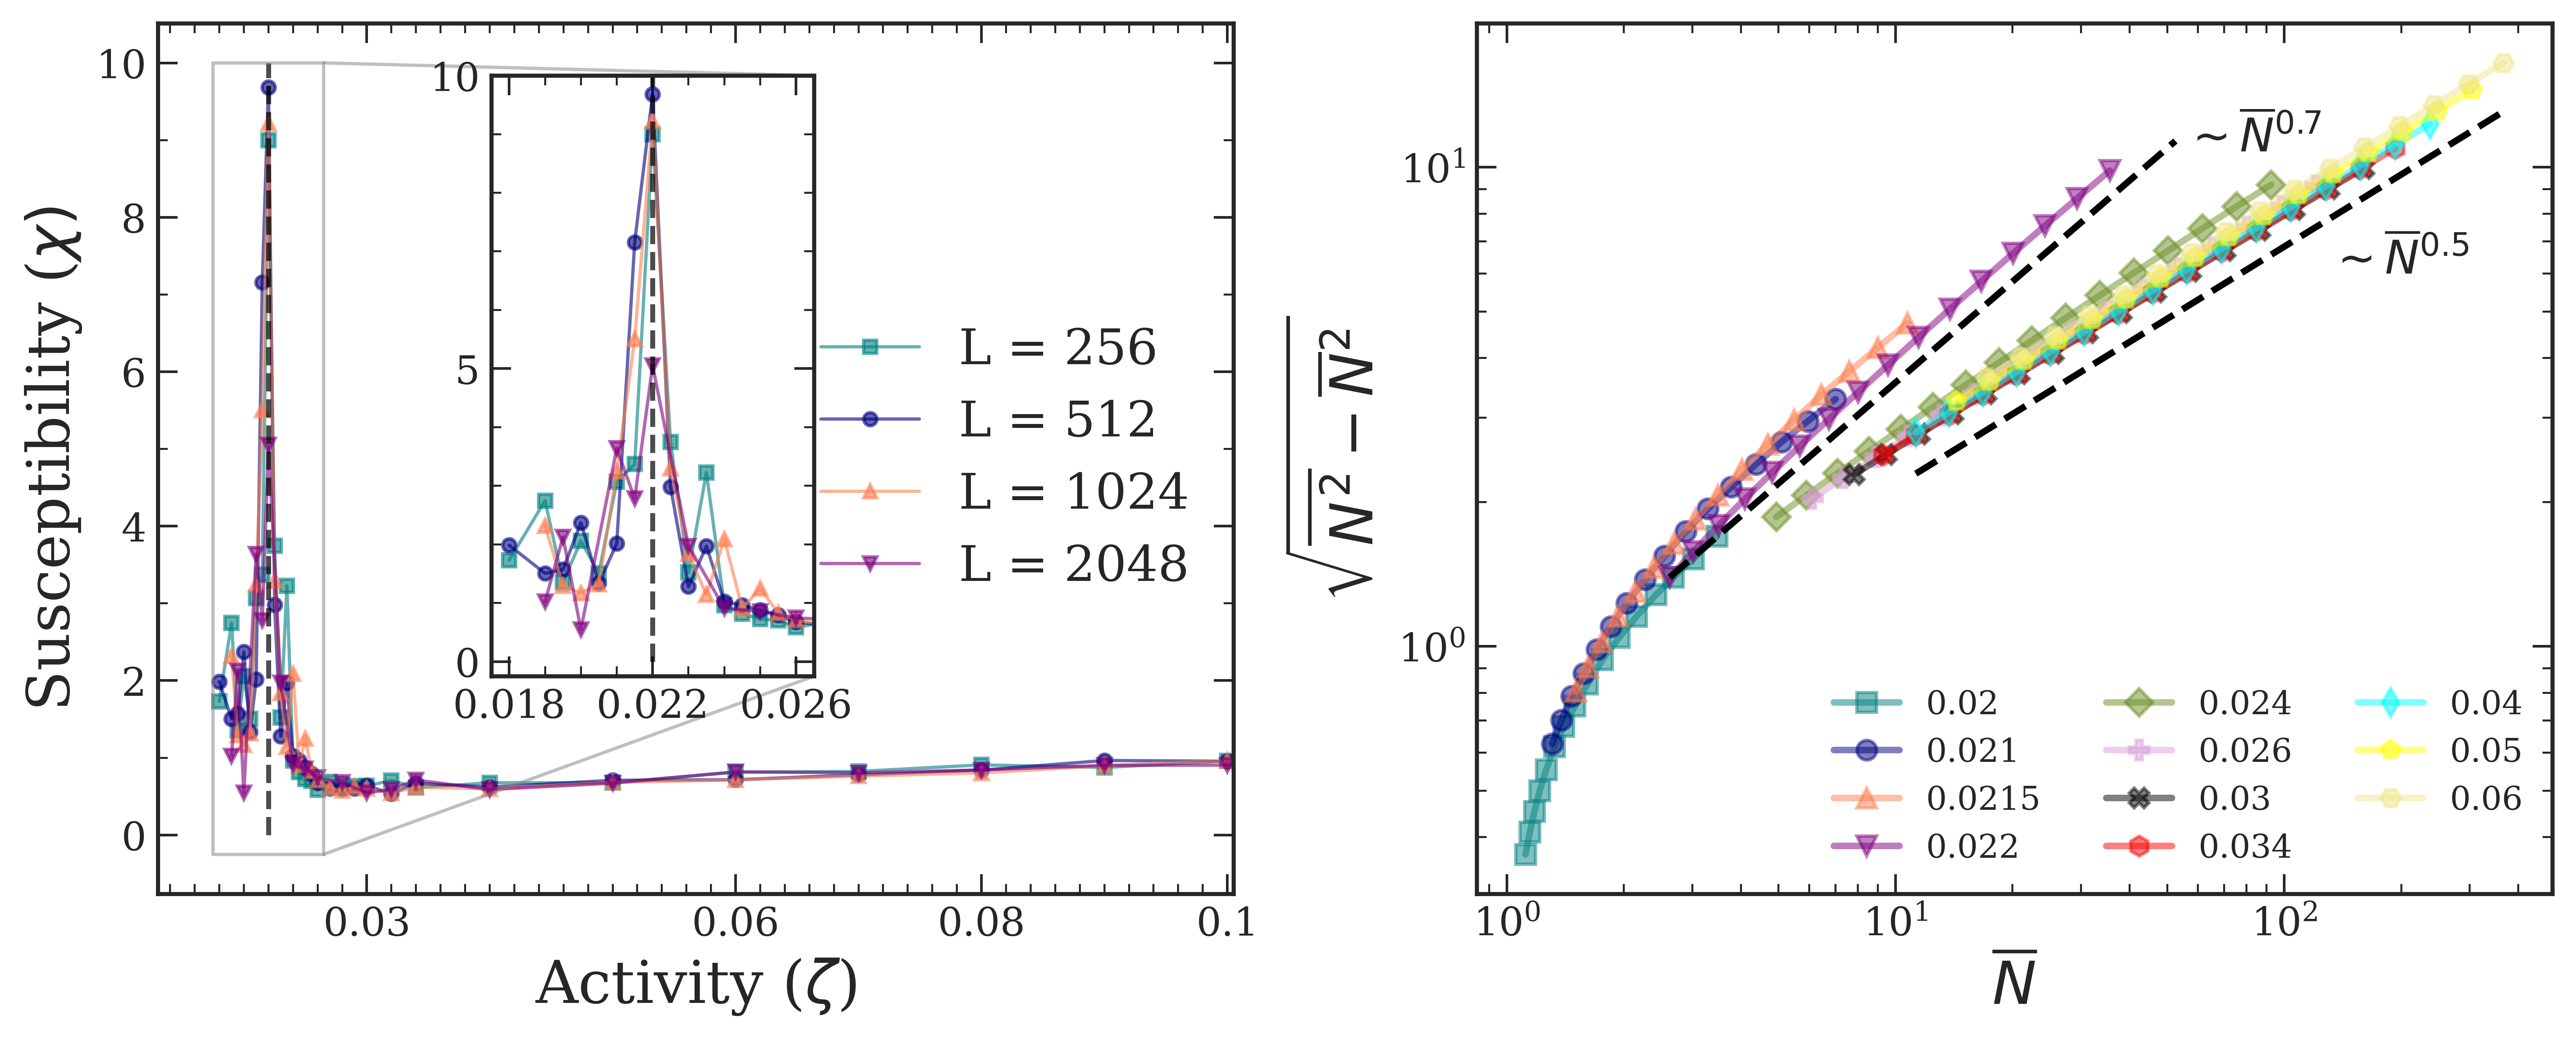

In [165]:

fig, ax0 = plt.subplots(nrows = 1, ncols = 2, figsize=(11,4.5)) 
marker_shape = ['s-', 'o-', '^-', 'v-', 'D-', 'P-', 'X-', 'h-', 'd-', 'p-', 'H-', '8-', '1-', '2-']
ax0 = ax0.flatten()
ax = ax0[0]
axx = ax0[1]
act_max = 0.022
normalize_sus = False

xmin = 0.37
ymin = 0.08
width = 0.3

axinn = ax.inset_axes([0.31, 0.25,width,2.3*width])

ax1_xlims = [0.013, 0.1005]
xticks = np.round(np.linspace(ax1_xlims[0], ax1_xlims[1], 5), 2)
ax.set(xticks=xticks,xticklabels=xticks, xlim=ax1_xlims,)

axinn_xlims = [0.0175, 0.0265]
axinn_ylims = [-.25, 10]
axinn_xticks = [1.8e-2, 2.2e-2,2.6e-2]
axinn_yticks = np.round(np.linspace(axinn_ylims[0]+.1, axinn_ylims[1] -.1,3)).astype('int')
axinn.set(xticks=axinn_xticks, yticks=axinn_yticks, xticklabels=axinn_xticks, yticklabels=axinn_yticks, xlim=axinn_xlims, ylim=axinn_ylims)
ax.indicate_inset_zoom(axinn)  

for N, act_list in enumerate(ada.act_list):

    sus = ada.get_binder_susceptibility(ada.LX[N])[1]
    act_max_idx = act_list.index(act_max)

    if normalize_sus:    
        sus = sus / sus[act_max_idx].max()

    label = f'L = {ada.LX[N]}'
    ax.plot(act_list, sus[:,0], f'{marker_shape[N]}', color = f'C{N}', alpha=.6, lw=1, markersize=4, label = label)
    axinn.plot(act_list, sus[:,0], f'{marker_shape[N]}', color = f'C{N}', alpha=.6, lw=1, markersize=4,)

ax.set_xlabel(r'Activity ($\zeta$)')
ax.set_ylabel(r'Susceptibility ($\chi)$')
axinn.vlines(act_max, 0, axinn_ylims[-1], color = 'k', lw=1.5, alpha=.7, linestyle = '--')
ax.vlines(act_max, 0, axinn_ylims[-1], color = 'k', lw = 1.5, linestyle = '--', alpha = .7)#, label = r'$\zeta=0.022$')
ax.yaxis.set_minor_locator(ticker.MultipleLocator(1))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(2e-3))
axinn.yaxis.set_minor_locator(ticker.MultipleLocator(1))
axinn.xaxis.set_minor_locator(ticker.MultipleLocator(1e-3))
#axinn.legend()
ax.legend()


window_idx_bounds = [10,-4]
marker_shape = ['s', 'o', '^', 'v', 'D', 'P', 'X', 'h', 'd', 'p', 'H', '8', '1', '2']
act_list = ad.act_list[0]

acts_to_plot = [0.02, 0.021, 0.0215, 0.022, 0.0225, 0.024, 0.026, 0.03, 0.034, 0.04, 0.05, 0.06]
if ad.LX[0] == 2048:
    acts_to_plot = [0.02, 0.021, 0.0215, 0.022, 0.024, 0.026, 0.03, 0.034, 0.04, 0.05, 0.06]
for i, act in enumerate(acts_to_plot):
    idx = act_list.index(act)
    axx.plot(av_counts_av[window_idx_bounds[0]:window_idx_bounds[1],idx,0], np.sqrt(var_counts_av[window_idx_bounds[0]:window_idx_bounds[1],idx,0]),\
             label=f'{act}', marker=marker_shape[i], alpha=.5)


idx22 = act_list.index(0.022)
idx40 = act_list.index(0.040)
scaling22 = (1+0.8/2)/2
window_idx_bounds = [10,-2]


#ax.plot(av_counts_av[:,idx,0], 0.8*av_counts_av[:,idx,0]**0.69, label=r'$\sim x^{0.7}$', color='black', lw=1.5, linestyle='--')
#ax.plot(av_counts_av[:,idx,0], 0.8*av_counts_av[:,idx,0]**0.5,label=r'$\sim x^{0.5}$', color='black', lw=1.5, linestyle='-')


x22, y22 = produce_scaling(av_counts_av[:, idx22, 0], scaling22, np.sqrt(var_counts_av[window_idx_bounds[0],idx22,0]), window_idx_bounds,)
x40, y40 = produce_scaling(av_counts_av[:, idx40, 0], .5, np.sqrt(var_counts_av[window_idx_bounds[0],idx40,0]), window_idx_bounds,)
axx.plot(x22, y22, color='black', linestyle='--')
axx.plot(x40, y40*0.82,  color='black', linestyle='--')
axx.text(130,6, r'$\sim \overline{N}^{0.5}$', fontsize=14)
axx.text(55,10.8, r'$\sim \overline{N}^{0.7}$', fontsize=14)

axx.set_xlabel(r'$\overline{N}$')
axx.set_ylabel(r'$\sqrt{\overline{N^2} - \overline{N}^2}$')
#ax.set_ylim(.5,8)
#ax.set_xlim(1,100)
axx.legend(ncols=3,fontsize=10)
axx.set_xscale('log')
axx.set_yscale('log')




fig.tight_layout()
fig.dpi = 720
#fig.savefig('data/nematic_analysis_all/susceptibility.eps', dpi = 720, pad_inches = .5)